In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from torchvision.transforms import ToTensor, Lambda, Compose
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from tqdm.auto import tqdm as tq
from PIL import Image

In [2]:
class Unet(nn.Module):
    def __init__(self, input_size=(256,256,3)):
        #x,y,z = input_size
        super(Unet, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 32, 3,padding='same')
        self.conv1_2 = nn.Conv2d(32, 32, 3,padding='same')
        #self.maxpool1 = nn.max_pool2d(2)
        
        self.conv2_1 = nn.Conv2d(32, 64, 3,padding='same')
        self.conv2_2 = nn.Conv2d(64, 64, 3,padding='same')
        #self.maxpool2 = nn.max_pool2d(2)
        
        self.conv3_1 = nn.Conv2d(64, 128, 3,padding='same')
        self.conv3_2 = nn.Conv2d(128, 128, 3,padding='same')
        #self.maxpool3 = nn.max_pool2d(2)
        
        self.conv4_1 = nn.Conv2d(128, 256, 3,padding='same')
        self.conv4_2 = nn.Conv2d(256, 256, 3,padding='same')
        self.dropout4 = nn.Dropout(0.5)
        #self.maxpool4 = nn.max_pool2d(2)
        
        self.conv5_1 = nn.Conv2d(256, 512, 3,padding='same')
        self.conv5_2 = nn.Conv2d(512, 512, 3,padding='same')
        self.dropout5 = nn.Dropout(0.5)
        
        self.up6 = nn.UpsamplingNearest2d(scale_factor=2)
        self.conv6_1 = nn.Conv2d(512, 256, 3,padding='same')
        #merge
        self.conv6_2 = nn.Conv2d(256, 256, 3,padding='same' )
        self.conv6_3 = nn.Conv2d(256, 256, 3,padding='same')
        
        self.up7 = nn.UpsamplingNearest2d(scale_factor=2)
        self.conv7_1 = nn.Conv2d(256, 128, 3, padding='same')
        #merge
        self.conv7_2 = nn.Conv2d(128, 128, 3, padding='same')
        self.conv7_3 = nn.Conv2d(128, 128, 3, padding='same')
        
        self.up8 = nn.UpsamplingNearest2d(scale_factor=2)
        self.conv8_1 = nn.Conv2d(128, 64, 3, padding='same')
        #merge
        self.conv8_2 = nn.Conv2d(64, 64, 3, padding='same')
        self.conv8_3 = nn.Conv2d(64, 64, 3, padding='same')

        self.up9 = nn.UpsamplingNearest2d(scale_factor=2)
        self.conv9_1 = nn.Conv2d(64, 32, 3, padding='same')
        #merge
        self.conv9_2 = nn.Conv2d(32, 32, 3, padding='same')
        self.conv9_3 = nn.Conv2d(32, 32, 3, padding='same')
        self.conv9_4 = nn.Conv2d(32, 2, 3, padding='same')

        self.conv10 = nn.Conv2d(2, 1, 3, padding='same')

        
   

    def forward(self, x):
        conv1 = F.relu(self.conv1_2(F.relu(self.conv1_1(x))))
        pool1 = F.max_pool2d(conv1, 2)
        conv2 = F.relu(self.conv2_2(F.relu(self.conv2_1(pool1))))
        pool2 = F.max_pool2d(conv2, 2)
        conv3 = F.relu(self.conv3_2(F.relu(self.conv3_1(pool2))))
        pool3 = F.max_pool2d(conv3, 2)
        
        conv4 = F.relu(self.conv4_2(F.relu(self.conv4_1(pool3))))
        drop4 = self.dropout4(conv4)
        pool4 = F.max_pool2d(drop4, 2)
        
        conv5 = F.relu(self.conv5_2(F.relu(self.conv5_1(pool4))))
        drop5 = self.dropout5(conv5)
        pool5 = F.max_pool2d(drop5, 2)
        
        up6 = nn.Upsample(scale_factor=2, mode='nearest')(drop5)
        conv6 = F.relu(self.conv6_1(up6))
        merge6 = concatenate([drop4,conv6], axis = 3)
        conv6 = F.relu(self.conv6_3(F.relu(self.conv6_2(merge6))))

        up7 = nn.Upsample(scale_factor=2, mode='nearest')(conv6)
        conv7 = F.relu(self.conv6_1(up6))
        merge7 = concatenate([conv3,conv7], axis = 3)
        conv7 = F.relu(self.conv7_3(F.relu(self.conv7_2(merge6))))

        up8 = nn.Upsample(scale_factor=2, mode='nearest')(conv7)
        conv8 = F.relu(self.conv6_1(up8))
        merge8 = concatenate([conv2,conv8], axis = 3)
        conv8 = F.relu(self.conv8_3(F.relu(self.conv8_2(merge8))))

        up9 = nn.Upsample(scale_factor=2, mode='nearest')(conv8)
        conv9 = F.relu(self.conv6_1(up9))
        merge9 = concatenate([conv1,conv9], axis = 3)
        conv9 = F.relu(self.conv9_3(F.relu(self.conv9_2(merge9))))
        conv9 = f.relu(self.conv9_4(conv9))
        output = F.sigmoid(self.conv10(conv9))
        return output


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [83]:
def train(n_epochs = 10):
    # number of epochs to train the model
    #n_epochs = 10
    train_loss_list = []
    valid_loss_list = []
    dice_score_list = []
    lr_rate_list = []
    valid_loss_min = np.Inf # track change in validation loss
    for epoch in range(1, n_epochs+1):

        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        dice_score = 0.0
        model.train()
        bar = tq(trainloader, postfix={"train_loss":0.0})
        for data, target in bar:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)
            #bar.set_postfix(ordered_dict={"train_loss":loss.item()})
        model.eval()
        del data, target
        with torch.no_grad():
            bar = tq(valloader, postfix={"valid_loss":0.0, "dice_score":0.0})
            for data, target in bar:
                # move tensors to GPU if CUDA is available
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()
                # forward pass: compute predicted outputs by passing inputs to the model
                output = model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # update average validation loss 
                valid_loss += loss.item()*data.size(0)
                dice_cof = dice_no_threshold(output.cpu(), target.cpu()).item()
                dice_score +=  dice_cof * data.size(0)
                #bar.set_postfix(ordered_dict={"valid_loss":loss.item(), "dice_score":dice_cof})

        # calculate average losses
        train_loss = train_loss/len(trainloader.dataset)
        valid_loss = valid_loss/len(valloader.dataset)
        dice_score = dice_score/len(valloader.dataset)
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        dice_score_list.append(dice_score)
        lr_rate_list.append([param_group['lr'] for param_group in optimizer.param_groups])

        # print training/validation statistics 
        print('Epoch: {}  Training Loss: {:.6f}  Validation Loss: {:.6f} Dice Score: {:.6f}'.format(
            epoch, train_loss, valid_loss, dice_score))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model_cifar.pt')
            valid_loss_min = valid_loss
    
        scheduler.step(valid_loss)

In [4]:
class double_conv(nn.Module):
    """(conv => BN => ReLU) * 2"""

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(nn.MaxPool2d(2), double_conv(in_ch, out_ch))

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="nearest", align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256, False)
        self.up2 = up(512, 128, False)
        self.up3 = up(256, 64, False)
        self.up4 = up(128, 64, False)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)

In [41]:
import torch
from skimage.io import imread
from torch.utils import data
import os

class dataset(data.Dataset):
    def __init__(self, image_paths, target_paths, train=True):   # initial logic happens like transform
        self.src_image = image_paths
        self.src_target = target_paths
        self.image_paths = os.listdir(image_paths)
        self.target_paths = os.listdir(target_paths)
        self.transforms = transforms.Compose([
                    #transforms.Resize((96,96)),
                    transforms.ToTensor(),
                    ])
        print('number of images:',len(self.image_paths),len(self.target_paths))
        
        
        
    def __getitem__(self, index):
        image = Image.open(os.path.join(self.src_image,self.image_paths[index])) 
        mask = Image.open(os.path.join(self.src_target,self.target_paths[index])).convert('L')
        image = np.array(image)
        t_image = self.transforms(image)
        t_mask = self.transforms(mask)
        return t_image, t_mask

    def __len__(self):  # return count of sample we have

        return len(self.image_paths)

In [48]:
train_dataset = dataset('./MaskTheFace/output_masked/img/','./MaskTheFace/output_mask/img/')
val_dataset   = dataset('./MaskTheFace/output_masked/img/','./MaskTheFace/output_mask/img/')
batch_size = 2
num_workers = 1
trainloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
)
valloader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
)

number of images: 97 97
number of images: 97 97


In [49]:
x,y = train_dataset.__getitem__(0)
print(x.shape,y.shape)
x,y = val_dataset.__getitem__(0)
print(x.shape,y.shape)

torch.Size([3, 96, 96]) torch.Size([1, 96, 96])
torch.Size([3, 96, 96]) torch.Size([1, 96, 96])


In [50]:
model = UNet(3,1)

In [84]:
train(2)

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.



Epoch: 1  Training Loss: 1.312588  Validation Loss: 1.321118 Dice Score: 0.348611
Validation loss decreased (inf --> 1.321118).  Saving model ...


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.



Epoch: 2  Training Loss: 1.311473  Validation Loss: 1.321498 Dice Score: 0.345653


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.



Epoch: 3  Training Loss: 1.311266  Validation Loss: 1.331406 Dice Score: 0.346930


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.



Epoch: 4  Training Loss: 1.314848  Validation Loss: 1.332019 Dice Score: 0.346319


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.



Epoch: 5  Training Loss: 1.310955  Validation Loss: 1.326473 Dice Score: 0.347698


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.



Epoch: 6  Training Loss: 1.314481  Validation Loss: 1.325825 Dice Score: 0.346967


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.



Epoch: 7  Training Loss: 1.310016  Validation Loss: 1.331722 Dice Score: 0.346302


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.



Epoch: 8  Training Loss: 1.313134  Validation Loss: 1.324645 Dice Score: 0.345802


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.



Epoch: 9  Training Loss: 1.313474  Validation Loss: 1.325216 Dice Score: 0.344819


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.



Epoch: 10  Training Loss: 1.313505  Validation Loss: 1.322488 Dice Score: 0.348869


In [20]:
criterion = BCEDiceLoss(eps=1.0, activation=None)
optimizer = RAdam(model.parameters(), lr = 0.005)
current_lr = [param_group['lr'] for param_group in optimizer.param_groups][0]
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, cooldown=2)
train_on_gpu = torch.cuda.is_available()

In [52]:
import math
import torch
from torch.optim.optimizer import Optimizer, required

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
            
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:            
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)

                p.data.copy_(p_data_fp32)

        return loss
    
def f_score(pr, gt, beta=1, eps=1e-7, threshold=None, activation='sigmoid'):
    """
    Args:
        pr (torch.Tensor): A list of predicted elements
        gt (torch.Tensor):  A list of elements that are to be predicted
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: IoU (Jaccard) score
    """

    if activation is None or activation == "none":
        activation_fn = lambda x: x
    elif activation == "sigmoid":
        activation_fn = torch.nn.Sigmoid()
    elif activation == "softmax2d":
        activation_fn = torch.nn.Softmax2d()
    else:
        raise NotImplementedError(
            "Activation implemented for sigmoid and softmax2d"
        )

    pr = activation_fn(pr)

    if threshold is not None:
        pr = (pr > threshold).float()


    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp
    fn = torch.sum(gt) - tp

    score = ((1 + beta ** 2) * tp + eps) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + eps)

    return score


class DiceLoss(nn.Module):
    __name__ = 'dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid'):
        super().__init__()
        self.activation = activation
        self.eps = eps

    def forward(self, y_pr, y_gt):
        return 1 - f_score(y_pr, y_gt, beta=1., 
                           eps=self.eps, threshold=None, 
                           activation=self.activation)


class BCEDiceLoss(DiceLoss):
    __name__ = 'bce_dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid', lambda_dice=1.0, lambda_bce=1.0):
        super().__init__(eps, activation)
        if activation == None:
            self.bce = nn.BCELoss(reduction='mean')
        else:
            self.bce = nn.BCEWithLogitsLoss(reduction='mean')
        self.lambda_dice=lambda_dice
        self.lambda_bce=lambda_bce

    def forward(self, y_pr, y_gt):
        dice = super().forward(y_pr, y_gt)
        bce = self.bce(y_pr, y_gt)
        return (self.lambda_dice*dice) + (self.lambda_bce* bce)
    
def dice_no_threshold(
    outputs: torch.Tensor,
    targets: torch.Tensor,
    eps: float = 1e-7,
    threshold: float = None,
):
    """
    Reference:
    https://catalyst-team.github.io/catalyst/_modules/catalyst/dl/utils/criterion/dice.html
    """
    if threshold is not None:
        outputs = (outputs > threshold).float()

    intersection = torch.sum(targets * outputs)
    union = torch.sum(targets) + torch.sum(outputs)
    dice = 2 * intersection / (union + eps)

    return dice

(1, 96, 96) float32
(96, 96, 3) float32
(1, 96, 96) float32


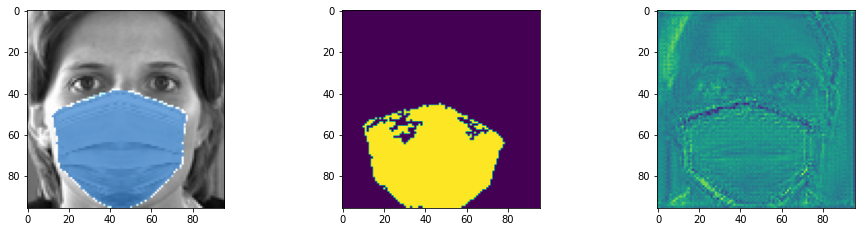

In [85]:
def fast_display(*img2dlist):
    plt.figure(figsize=(16,8))
    nbimg = len(img2dlist)
    cols = min (9,nbimg)
    rows = (nbimg // cols) +1
    for ii, img2d in enumerate(img2dlist):
        plt.subplot(rows,cols,1+ii)
        plt.imshow(img2d)
    plt.show()
    
x,y = train_dataset.__getitem__(0)
for i, (data, target) in enumerate(trainloader):
    if train_on_gpu:
        data = data.cuda()
    output = ((model(data))[0]).cpu().detach().numpy()
x = x.numpy() 
y = y.numpy() 
x = np.moveaxis(x, 0, 2)
print(output.shape ,output.dtype)
print(x.shape ,x.dtype)
print(y.shape ,y.dtype)
fast_display(x ,y[0],output[0] )